In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf 
from matplotlib import pyplot as plt
from PIL import Image
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Lambda, Dense, Flatten, Input
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

import os
from sklearn.model_selection import StratifiedKFold
import random as rd

In [15]:
ds_path = '/content/drive/MyDrive/utkface'
#ds_path= '/Users/elenarodriguez/Documents/Escuela/4to/ML/Proyecto/bias-project-ML/datasets/utkface/'

In [18]:
filenames= os.listdir(ds_path)

In [19]:
# Building the dataframe
df = pd.DataFrame(filenames, columns = ['filename'])
df['filepath'] = df.filename.apply(lambda x: ds_path + x )
df['age'] = df.filename.apply(lambda x: int(x.split('_')[0]))
df['gender'] = df.filename.apply(lambda x: int(x.split('_')[1]))
df['race'] = df.filename.apply(lambda x: int(x.split('_')[2]))

In [20]:
IMG_WIDTH, IMG_HEIGHT = 96, 96
race_mapper = {0:'white', 1:'black',2: 'asian',3: 'indian', 4:'other'}
gender_mapper = {0:'male',1:'female'}
df.head()

,filename,filepath,age,gender,race
0,82_0_2_20170112224024582.jpg.chip.jpg,/content/drive/MyDrive/utkface82_0_2_201701122...,82,0,2
1,84_1_0_20170110160644173.jpg.chip.jpg,/content/drive/MyDrive/utkface84_1_0_201701101...,84,1,0
2,79_1_0_20170120225840978.jpg.chip.jpg,/content/drive/MyDrive/utkface79_1_0_201701202...,79,1,0
3,80_0_1_20170111205423680.jpg.chip.jpg,/content/drive/MyDrive/utkface80_0_1_201701112...,80,0,1
4,96_1_0_20170110183855839.jpg.chip.jpg,/content/drive/MyDrive/utkface96_1_0_201701101...,96,1,0


In [12]:
df.describe()
;

''

In [ ]:
#plt.figure(figsize=(10,10))
#for i in range(9):
    #sample = df.loc[i]
    #plt.subplot(3,3,i+1)
    #plt.axis('off')
    #plt.title('%i, %s, %s' % (sample.age,race_mapper[sample.race],gender_mapper[sample.gender]))
    #plt.imshow(Image.open(ds_path + sample.filename))


In [ ]:
def feature_extract( inputs):
    l1 = inputs
    l2 = Conv2D(64, (3,3), padding='same', activation='relu')(l1)
    l3 = Conv2D(64, (3,3), padding='same', activation='relu')(l2)
    l4 = MaxPooling2D((2,2), strides=(2,2))(l3)
    l5 = Conv2D(128, (3,3), padding='same', activation='relu')(l4)
    l6 = Conv2D(128, (3,3), padding='same', activation='relu')(l5)
    l7 = MaxPooling2D((2,2), strides=(2,2))(l6)
    l8 = Conv2D(256, (3,3), padding='same', activation='relu')(l7)
    l9 = Conv2D(256, (3,3), padding='same', activation='relu')(l8)
    l10 = Conv2D(256, (3,3), padding='same', activation='relu')(l9)
    l11 = MaxPooling2D((2,2), strides=(2,2))(l10)
    l12 = Conv2D(512, (3,3), padding='same', activation='relu')(l11)
    l13 = Conv2D(512, (3,3), padding='same', activation='relu')(l12)
    l15 = Conv2D(512, (3,3), padding='same', activation='relu')(l13)
    l16 = MaxPooling2D((2,2), strides=(2,2))(l15)
    l17 = Conv2D(512, (3,3), padding='same', activation='relu')(l16)
    l18 = Conv2D(512, (3,3), padding='same', activation='relu')(l17)
    l19 = Conv2D(512, (3,3), padding='same', activation='relu')(l18)
    l20 = MaxPooling2D((2,2), strides=(2,2))(l19)
    return l20

def age_branch( inputs):
    l1 = tf.keras.layers.Flatten()(inputs)
    l2 = tf.keras.layers.Dense(256, activation='relu')(l1)
    l3 = tf.keras.layers.Dense(256, activation='relu')(l2)
    l4 = tf.keras.layers.Dense(1, activation='linear', name="age_output")(l3)
    return l4

def gender_branch( inputs, num_genders=2):
    l1 = tf.keras.layers.Flatten()(inputs)
    l2 = tf.keras.layers.Dense(128, activation='relu')(l1)
    l3 = tf.keras.layers.Dense(64, activation='relu')(l2)
    l4 = tf.keras.layers.Dense(num_genders, activation='softmax', name="gender_output")(l3)
    return l4

def race_branch( inputs, num_races):
    l1 = tf.keras.layers.Flatten()(inputs)
    l2 = tf.keras.layers.Dense(128, activation='relu')(l1)
    l3 = tf.keras.layers.Dense(64, activation='relu')(l2)
    l4 = tf.keras.layers.Dense(num_races, activation='softmax', name="race_output")(l3)
    return l4

def full_model( width, height, num_races):
    input_shape = (height, width, 3)
    inputs = tf.keras.layers.Input(shape=input_shape)
    feature_extractor = feature_extract(inputs)
    age_output = age_branch(feature_extractor)
    gender_output = gender_branch(feature_extractor)
    race_output = race_branch(feature_extractor, num_races)
    model = tf.keras.Model(inputs=inputs,
                  outputs=[age_output, race_output, gender_output],
                  name="utk_face_net")
    return model

In [ ]:
model = full_model(IMG_WIDTH,IMG_HEIGHT, len(race_mapper))

In [ ]:
model.summary()
plot_model(model)

Model: "utk_face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 96, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 48, 64)   0           ['conv2d_1[0][0]']               
                                                                                       

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss={
                  'age_output': 'mse',
                  'race_output': 'categorical_crossentropy',
                  'gender_output': 'binary_crossentropy'},

              metrics={
                  'age_output': 'mae',
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

In [ ]:
def stratified_KFold(k, data):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    X=data['filepath']
    y=data['gender']+ data['race']

    r= rd.randint(0,k-1)

    #lst_accu_stratified = []

    for i,(train_index, test_index) in enumerate(skf.split(X, y)):
        #x_train_fold, x_test_fold = X[train_index], X[test_index]
        #y_train_fold, y_test_fold = y[train_index], y[test_index]
        #print(f"Fold {i}:")
        #print(f"  Train: index={train_index}")
        #print(f"  Test:  index={test_index}")
        if(i==r):
            return train_index, test_index
        #model.fit(x_train_fold, y_train_fold)
        #lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))

In [ ]:
train_data_idx, test_data_idx= stratified_KFold(5, df)
train_data= df.loc[train_data_idx]
test_data= df.loc[test_data_idx]

In [ ]:
def proccess_data(df):
    images = []
    for i in range(len(df)):
        img = np.array(Image.open(df['filepath'][i]).resize((IMG_WIDTH,IMG_HEIGHT))) / 255.
        
        images.append(img)

        df['age']= df.age.apply(lambda x: x/116.)
        df['gender'][i]= gender_mapper[df['gender'][i]]
        df['race'][i]= race_mapper[df['race'][i]]
    images= np.array(images)
    
    return images,df

In [ ]:
# Processing data 
images, df= proccess_data(df)

/var/folders/nd/6xwcfr9x3j7dc8rl2l28_mjc0000gn/T/ipykernel_2022/597890446.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'][i]= gender_mapper[df['gender'][i]]
/var/folders/nd/6xwcfr9x3j7dc8rl2l28_mjc0000gn/T/ipykernel_2022/597890446.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race'][i]= race_mapper[df['race'][i]]


In [ ]:
train_images= images[train_data_idx]
test_images= images[test_data_idx]

In [ ]:
images_train, images_val, ages_train,ages_val, races_train,races_val,genders_train,genders_val= train_test_split(train_images, df['age'][train_data_idx],df['race'][train_data_idx], df['gender'][train_data_idx],test_size=0.15)

In [ ]:
#images_test,ages_test,races_test,genders_test= proccess_data(data_x_test, data_y_test)

In [ ]:
#images_train, images_val, ages_train,ages_val, races_train,races_val,genders_train,genders_val  = train_test_split(images, np.array(ages),np.array(races),np.array(genders),test_size=0.15)

In [ ]:
len(images_train)

16121

In [ ]:
len(images_val)

2845

In [ ]:
len(test_images)

4742

In [ ]:
train_y = [ages_train,races_train,genders_train]
val_y =  [ages_val,genders_val,races_val]

In [ ]:
history = model.fit(images_train,train_y, validation_data=(images_val,val_y),  epochs=10  )

Epoch 1/10
266/266 [==============================] - 1788s 7s/step - loss: 2.1780 - age_output_loss: 0.0386 - race_output_loss: 1.4467 - gender_output_loss: 0.6927 - age_output_mae: 0.1519 - race_output_accuracy: 0.4251 - gender_output_accuracy: 0.5241 - val_loss: 2.1305 - val_age_output_loss: 0.0346 - val_race_output_loss: 1.4046 - val_gender_output_loss: 0.6913 - val_age_output_mae: 0.1439 - val_race_output_accuracy: 0.4293 - val_gender_output_accuracy: 0.5167
Epoch 2/10
266/266 [==============================] - 1556s 6s/step - loss: 1.9320 - age_output_loss: 0.0314 - race_output_loss: 1.2910 - gender_output_loss: 0.6096 - age_output_mae: 0.1359 - race_output_accuracy: 0.5001 - gender_output_accuracy: 0.6520 - val_loss: 1.6848 - val_age_output_loss: 0.0249 - val_race_output_loss: 1.1490 - val_gender_output_loss: 0.5109 - val_age_output_mae: 0.1232 - val_race_output_accuracy: 0.5640 - val_gender_output_accuracy: 0.7480
Epoch 3/10
266/266 [==============================] - 1550s 6s/s

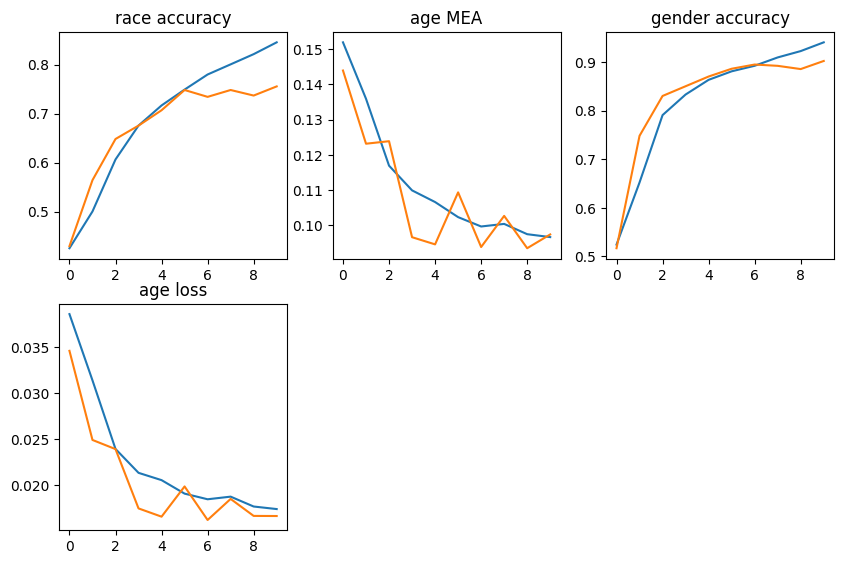

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.title('race accuracy')
plt.plot(range(10), history.history['race_output_accuracy'],history.history['val_race_output_accuracy'])

plt.subplot(3,3,2)
plt.title('age MEA')
plt.plot(range(10), history.history['age_output_mae'],history.history['val_age_output_mae'])

plt.subplot(3,3,3)
plt.title('gender accuracy')
plt.plot(range(10), history.history['gender_output_accuracy'],history.history['val_gender_output_accuracy'])


plt.subplot(3,3,4)
plt.title('age loss')
plt.plot(range(10), history.history['age_output_loss'],history.history['val_age_output_loss'])

In [ ]:
metrics_names= model.metrics_names
metricts_value= model.evaluate(test_images, [np.array(test_data['age']),np.array(test_data['gender']),np.array(test_data['race'])])


32/32 [==============================] - 86s 3s/step - loss: 1.1362 - age_output_loss: 0.0162 - race_output_loss: 0.7462 - gender_output_loss: 0.3738 - age_output_mae: 0.0985 - race_output_accuracy: 0.7570 - gender_output_accuracy: 0.8600


[1.136225700378418,
 0.016229795292019844,
 0.7462149858474731,
 0.37378063797950745,
 0.09847096353769302,
 0.7570000290870667,
 0.8600000143051147]

In [ ]:
predict= model.predict(test_images)

1/1 [==============================] - 1s 804ms/step
 Predict 28, asian, female
 Predict 39, black, male
 Predict 47, white, female
 Predict 30, indian, female
 Predict 25, black, male
 Predict 63, black, male
 Predict 32, white, female
 Predict 30, white, male
 Predict 40, indian, male
 Predict 31, indian, female


In [ ]:
pred_result= pd.DataFrame()
pred_result['image_path']= df['filepath'][test_data_idx]

In [ ]:
predicted_age=[]
predicted_gender=[]
predicted_race=[]

for i in range(len(predict[0])):
    predicted_age.append(int(predict[0][i] * 100))
    predicted_race.append(race_mapper[np.argmax(predict[1][i])])
    predicted_gender.append(gender_mapper[np.argmax(predict[2][i])])

pred_result['pred_age']= predicted_age
pred_result['pred_gender']= predicted_gender
pred_result['pred_race']= predicted_race

pred_result['real_age']= test_data['age']
pred_result['real_gender']= test_data['gender']
pred_result['real_race']= test_data['race']

In [ ]:
pred_result

,image_path,pred_age,pred_gender,pred_race
0,/Users/elenarodriguez/Documents/Escuela/4to/ML...,28,female,asian
1,/Users/elenarodriguez/Documents/Escuela/4to/ML...,39,male,black
2,/Users/elenarodriguez/Documents/Escuela/4to/ML...,47,female,white
3,/Users/elenarodriguez/Documents/Escuela/4to/ML...,30,female,indian
4,/Users/elenarodriguez/Documents/Escuela/4to/ML...,25,male,black
5,/Users/elenarodriguez/Documents/Escuela/4to/ML...,63,male,black
6,/Users/elenarodriguez/Documents/Escuela/4to/ML...,32,female,white
7,/Users/elenarodriguez/Documents/Escuela/4to/ML...,30,male,white
8,/Users/elenarodriguez/Documents/Escuela/4to/ML...,40,male,indian
9,/Users/elenarodriguez/Documents/Escuela/4to/ML...,31,female,indian


In [ ]:
predict

[array([[0.24221808],
        [0.3447449 ],
        [0.40939492],
        [0.26115546],
        [0.216456  ],
        [0.5452107 ],
        [0.28230235],
        [0.26547876],
        [0.3506151 ],
        [0.27281943]], dtype=float32),
 array([[6.77026995e-03, 9.28552151e-02, 8.76432240e-01, 1.14708592e-03,
         2.27951668e-02],
        [2.35162284e-02, 9.62868035e-01, 5.60464396e-04, 1.01591963e-02,
         2.89601972e-03],
        [9.37284052e-01, 1.33519084e-03, 4.97578271e-02, 1.29770779e-03,
         1.03251897e-02],
        [1.86112583e-01, 2.76825819e-02, 6.82246536e-02, 5.59519589e-01,
         1.58460513e-01],
        [2.28743330e-01, 4.07653511e-01, 1.86622515e-02, 1.28445074e-01,
         2.16495752e-01],
        [1.04513675e-01, 7.30057061e-01, 1.83179677e-02, 1.17064364e-01,
         3.00469529e-02],
        [9.69700217e-01, 2.48663302e-04, 1.28612295e-03, 2.76493304e-03,
         2.59998739e-02],
        [7.36374021e-01, 6.88241154e-04, 2.04484776e-01, 2.64756270e-0

1/1 [==============================] - 0s 102ms/step


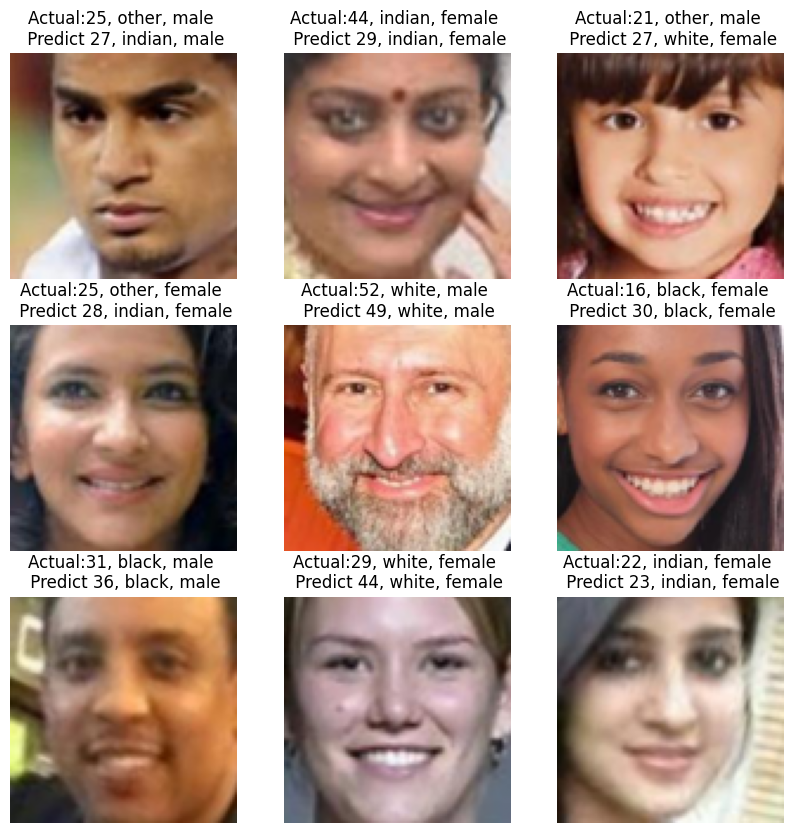

In [ ]:
# Ejemplo para visualizar la prediccion
plt.figure(figsize=(10,10))
for i in range(9):
    sample = df.loc[i+250]
    img = np.array(Image.open(sample.filepath).resize((IMG_WIDTH,IMG_HEIGHT)) ) / 255.
    predict = model.predict(np.array([img])) 
    plt.subplot(3,3,i+1)
    age = int(predict[0] * 116)
    race = race_mapper[np.argmax(predict[1])]
    gender = gender_mapper[np.argmax(predict[2])]
    plt.axis('off')
    plt.title('Actual:%i, %s, %s \n Predict %i, %s, %s' % (sample.age,race_mapper[sample.race],gender_mapper[sample.gender], age, race, gender))
    plt.imshow(img) 

In [ ]:
model.save('model.h5')